In [1]:
# !pip install oilmm
# !pip install tensorflow

In [2]:
# !pip install package
# !pip install -U tensorflow-probability

In [1]:
import numpy as np
from stheno import EQ, GP

# Use TensorFlow as the backend for the OILMM.
import tensorflow as tf
from oilmm.tensorflow import OILMM

2023-01-18 12:46:50.801456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/desai.aadesh/miniconda3/envs/mogp/lib/python3.10/site-packages/tensorflow/python/framework/dtypes.py:246: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
2023-01-18 12:46:51.823770: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/lib64:
2023-01-18 12:46:51.823863: W tensorflow/compiler/xla/stream_execut

In [2]:
def build_latent_processes(ps):
    # Return models for latent processes, which are noise-contaminated GPs.
    return [
        (
            p.variance.positive(1) * GP(EQ().stretch(p.length_scale.positive(1))),
            p.noise.positive(1e-2),
        )
        for p, _ in zip(ps, range(4))
       
    ]

In [3]:
# Construct model. 
# 
import math
import torch 
prior = OILMM(tf.float32, build_latent_processes, num_outputs=2)

# # Create some sample data.
# x1 = np.linspace(0, 10, 100).reshape(-1,1)
# x2 = np.linspace(0, 10, 100).reshape(-1,1)
# x = np.concatenate((x1,x2), axis = 1)
# print(x.shape)
# y = prior.sample(x)  # Sample from the prior.

# train_x = torch.stack([torch.linspace(0, 1, 100),
# torch.linspace(0, 2, 100)
# ],-1)
# train_x1 = torch.linspace(0, 1, 100)

# train_y = torch.stack([
#     torch.sin(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2,
#     torch.cos(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2,
#     torch.sin(train_x1 * (2 * math.pi)) + 2 * torch.cos(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2,
#     -torch.cos(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2,
# ], -1)

# print(train_x.shape, train_y.shape)

In [6]:
import math
import torch
# import gpytorch
# import tqdm
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy import stats
from time import time
import os


In [7]:
def return_data(fold,month,with_scaling, station_id = None):
    train_input = pd.read_csv('AAAI22/data/processed'+'/fold_'+str(fold)+'_train_'+month+'.csv.gz')
    test_input = pd.read_csv('AAAI22/data/processed'+'/fold_'+str(fold)+'_test_'+month+'.csv.gz')
    if station_id != None:
        test_input = test_input[test_input['station_id'] == station_id]
    test_output = np.concatenate((np.array(test_input['PM25_Concentration']).reshape(-1,1), np.array(test_input['CO_Concentration']).reshape(-1,1)), axis=1)
    train_output = np.concatenate((np.array(train_input['PM25_Concentration']).reshape(-1,1), np.array(train_input['CO_Concentration']).reshape(-1,1)), axis=1)
    train_input= train_input.drop(['station_id','PM25_Concentration','CO_Concentration','time','filled'],axis=1)
    try:
        test_input= test_input.drop(['PM25_Concentration','CO_Concentration','station_id','time','filled'],axis=1)
    except:
        test_input= test_input.drop(['station_id','time','filled'],axis=1)
    if with_scaling:
        scaler_x = StandardScaler()
        scaler_y = StandardScaler()
        # scaler = MinMaxScaler().fit(train_input)
        # train_input = pd.DataFrame(scaler_x.fit_transform(train_input),columns=list(train_input.columns))
        # train_output = scaler_y.fit_transform(train_output)
        # test_input = pd.DataFrame(scaler_x.transform(test_input),columns=list(test_input.columns))
        # scaler = MinMaxScaler().fit(train_input)
        train_input = torch.tensor(scaler_x.fit_transform(train_input)).to(torch.float32)
        test_input = torch.tensor(scaler_x.transform(test_input)).to(torch.float32)
        train_output = torch.tensor(scaler_y.fit_transform(train_output)).to(torch.float32)
        test_output = torch.tensor(test_output).to(torch.float32)
    return train_input,train_output,test_input,test_output, scaler_y

In [8]:
for fold in [0]:
    train_input,train_output,test_input,test_output,scaler_y = return_data(fold=fold,month='mar',with_scaling=True)
    print("Fold: ",fold)
    print("Data received")

Fold:  0
Data received


In [9]:
x = np.array(train_input)
y = np.array(train_output)

In [10]:
# Fit the model to the data.
prior.fit(x, y, trace=True, jit=True)
prior.vs.print()  # Print all learned parameters

2023-01-18 12:48:39.032015: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/lib64:
2023-01-18 12:48:39.032088: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-01-18 12:48:39.032998: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[166440,166440] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Mul]

In [11]:
# Make predictions.

num_tasks = 2
# test_x = torch.stack([ torch.linspace(0, 1, 51),
# torch.linspace(0, 2, 51)],-1)
# print(test_x.shape)
posterior = prior.condition(x, y)  # Construct posterior model.
mean, var = posterior.predict(np.array(test_input))  # Predict with the posterior model.
lower = mean - 1.96 * np.sqrt(var)
upper = mean + 1.96 * np.sqrt(var)

2023-01-18 12:49:38.272124: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2023-01-18 12:49:38.286774: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 110809094400 exceeds 10% of free system memory.
2023-01-18 12:49:43.672286: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 110809094400 exceeds 10% of free system memory.
2023-01-18 12:49:43.672530: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at matmul_op_impl.h:731 : RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[166440,166440] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
/home/desai.aadesh/miniconda3/envs/mogp/lib/python3.10/site-packages/oilmm/oilmm.py:48: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.noise is 0:
/home/desai.aadesh/miniconda3/envs/mogp/lib/python3.10/site-packages/oilm

ResourceExhaustedError: {{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[166440,166440] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:MatMul]

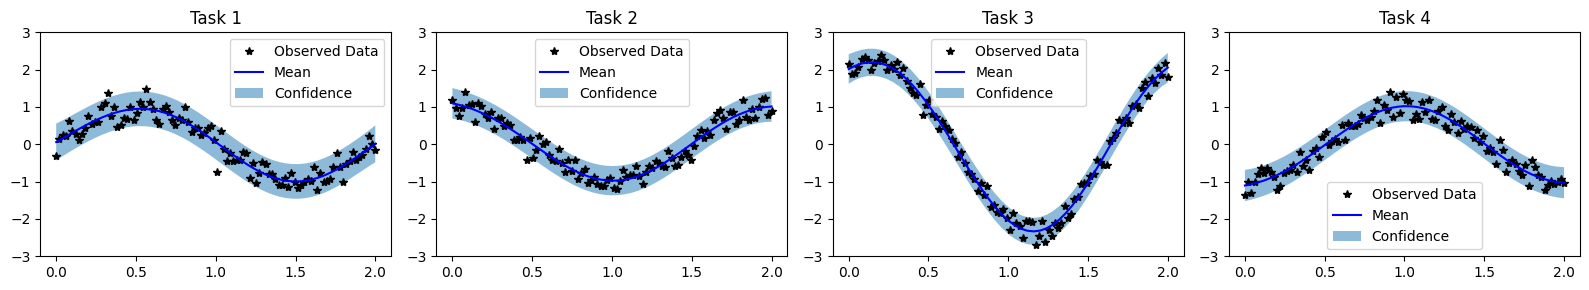

In [58]:
# Initialize plots
fig, axs = plt.subplots(1, num_tasks, figsize=(4 * num_tasks, 3))
for task, ax in enumerate(axs):
    # Plot training data as black stars
    ax.plot(train_x[:,1].detach().numpy(), train_y[:, task].detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x[:,1].numpy(), mean[:, task], 'b')
    # Shade in confidence
    ax.fill_between(test_x[:,1].numpy(), lower[:, task], upper[:, task], alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(f'Task {task + 1}')

fig.tight_layout()
None